In [1]:
import torch
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any, Callable


%load_ext autoreload
%autoreload 2


import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.stochastic_interpolant as stochastic_interpolant
import interflow.gmm as gmm


from torch import autograd
from functorch import jacfwd, vmap


if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found!')
print(itf.util.get_torch_device())


print("Torch version:", torch.__version__)

No CUDA device found!
cpu
Torch version: 1.13.1+cu116


In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import gridspec
mpl.rcParams['axes.grid']  = True
mpl.rcParams['axes.grid.which']  = 'both'
mpl.rcParams['xtick.minor.visible']  = True
mpl.rcParams['ytick.minor.visible']  = True
mpl.rcParams['xtick.minor.visible']  = True
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = '0.8'
mpl.rcParams['grid.alpha'] = '0.5'
mpl.rcParams['figure.figsize'] = (8, 4)
mpl.rcParams['figure.titlesize'] = 12.5
mpl.rcParams['font.size'] = 12.5
mpl.rcParams['legend.fontsize'] = 12.5
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.usetex'] = False

## Utility functions

In [3]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()


def compute_likelihoods(
    v: torch.nn.Module,
    s: torch.nn.Module,
    log_rho0: Callable[[torch.tensor], torch.tensor],
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_likelihood: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    sde_flow = stochastic_interpolant.SDEIntegrator(
        v=v, s=s, dt=torch.tensor(1e-2), eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=n_likelihood
    )

    pflow = stochastic_interpolant.PFlowIntegrator(v=v, s=s,  
                                                   method='dopri5', 
                                                   interpolant=interpolant,
                                                   n_step=3)

    with torch.no_grad():
        x0_tests  = base(bs)
        xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
        xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]

        # ([n_likelihood, bs, dim], [bs])
        x0s_sdeflow, dlogps_sdeflow = sde_flow.rollout_likelihood(xfs_sde[-1])
        log_p0s = torch.reshape(
            log_rho0(x0s_sdeflow.reshape((n_likelihood*bs, ndim))),
            (n_likelihood, bs)
        )
        logpx_sdeflow = torch.mean(log_p0s, axis=0) - dlogps_sdeflow


    logp0                  = log_rho0(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]


    return xf_sde, logpx_sdeflow, xf_pflow, logpx_pflow


def log_metrics(
    v: torch.nn.Module,
    s: torch.nn.Module,
    exact_interpolant: gmm.GMMInterpolant,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_likelihood: int,
    likelihood_bs: int, 
    v_loss: torch.tensor,
    s_loss: torch.tensor,
    loss: torch.tensor,
    v_grad: torch.tensor,
    s_grad: torch.tensor,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    # log loss and gradient data
    v_loss   = grab(v_loss).mean();   data_dict['v_losses'].append(v_loss)
    s_loss   = grab(s_loss).mean();   data_dict['s_losses'].append(s_loss)
    loss     = grab(loss).mean();     data_dict['losses'].append(loss)
    v_grad   = grab(v_grad).mean();   data_dict['v_grads'].append(v_grad)
    s_grad   = grab(s_grad).mean();   data_dict['s_grads'].append(s_grad)

    # compute and log likelihood data
    _, logpx_sdeflow, _, logpx_pflow = compute_likelihoods(
        v, s, exact_interpolant.log_rho0, interpolant, n_save, n_likelihood, eps, likelihood_bs
    )

    # compute kl and log data
    kl_pflow, kl_sdeflow = compute_kl(v, s, exact_interpolant, interpolant, eps, likelihood_bs)
    kl_pflow = grab(kl_pflow).mean(); data_dict['kl_pflow'].append(kl_pflow)
    kl_sdeflow = grab(kl_sdeflow).mean(); data_dict['kl_sdeflow'].append(kl_sdeflow)

    # compute norm of difference between exact v,s and model v-hat, s-hat
    v_vhat_diff, s_shat_diff = compute_v_diff(v, s, target, exact_interpolant, bs = likelihood_bs) 
    v_vhat_diff = grab(v_vhat_diff).mean(); data_dict['v_vhat_diff'].append(v_vhat_diff)
    s_shat_diff = grab(s_shat_diff).mean(); data_dict['s_shat_diff'].append(s_shat_diff)

    logpx_sdeflow = grab(logpx_sdeflow).mean(); data_dict['logps_sdeflow'].append(logpx_sdeflow)
    logpx_pflow = grab(logpx_pflow).mean(); data_dict['logps_pflow'].append(logpx_pflow)
    
    
def make_plots(
    v: torch.nn.Module,
    s: torch.nn.Module,
    log_rho0: Callable[[torch.tensor], torch.tensor],
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_likelihood: int,
    likelihood_bs: int,
    counter: int,
    metrics_freq: int,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    """Make plots to visualize samples and evolution of the likelihood."""
    # compute likelihood and samples for SDE and probability flow.
    xf_sde, logpx_sdeflow, xf_pflow, logpx_pflow = compute_likelihoods(
        v, s, log_rho0, interpolant, n_save, n_likelihood, eps, likelihood_bs
    )


    ### plot the loss, test logp, and samples from interpolant flow
    fig, axes = plt.subplots(1,5, figsize=(19,4))
    print("EPOCH:", counter)
    print("LOSS, GRAD:", loss, v_grad, s_grad)


    # plot loss over time.
    nsaves = len(data_dict['losses'])
    epochs = np.arange(nsaves)*metrics_freq
    axes[0].plot(epochs, data_dict['losses'], label=" v + s")
    axes[0].plot(epochs, data_dict['v_losses'], label="v")
    axes[0].plot(epochs, data_dict['s_losses'], label = "s" )
    axes[0].set_xlabel("Epoch", fontsize = 12)
    axes[0].set_title("LOSS")
    axes[0].legend()


    # plot samples from SDE.
    axes[1].scatter(
        xf_sde[:,0], xf_sde[:,1], vmin=0.0, vmax=0.05, alpha = 0.2, c=grab(torch.exp(logpx_sdeflow).detach()))
    axes[1].set_xlim(-10,10)
    axes[1].set_ylim(-10,10)
    axes[1].set_title("Cross-Section from SDE", fontsize=14)
    axes[1].set_xlabel(r"$x$, $d=0$", fontsize = 12)
    axes[1].set_ylabel(r"$x$, $d=1$", fontsize = 12)


    # plot samples from pflow
    axes[2].scatter(
        xf_pflow[:,0], xf_pflow[:,1], vmin=0.0, vmax=0.05, alpha = 0.2, c=grab(torch.exp(logpx_pflow).detach()))
    axes[2].set_xlim(-10,10)
    axes[2].set_ylim(-10,10)
    axes[2].set_title("Cross-Section from PFlow", fontsize=14)
    axes[2].set_xlabel(r"$x$, $d=0$", fontsize = 12)
    axes[2].set_ylabel(r"$x$, $d=1$", fontsize = 12)


    # plot likelihood estimates.
    print( data_dict['kl_pflow'])
    # epochs = epochs[:-1]
    axes[3].plot(epochs, data_dict['kl_pflow'],   label='pflow', color='purple')
    axes[3].plot(epochs, data_dict['kl_sdeflow'], label='sde',   color='red')
    axes[3].set_title(r"$KL(\rho_1(x) | \hat\rho(1,x) )$")
    axes[3].legend(loc='best')
    ymax = max(data_dict['kl_pflow'])
    # axes[3].set_ylim(-5,ymax + ymax*.01)
    axes[3].set_yscale("log")
    axes[3].set_xlabel("Epoch", fontsize = 12)

    print( data_dict['v_vhat_diff'])
    axes[4].plot(epochs, data_dict['v_vhat_diff'],   label=r'$o = v$', color='purple')
    axes[4].plot(epochs, data_dict['s_shat_diff'], label=r'$ o = s$',   color='red')
    axes[4].set_title(r"$\int_0^1 dt | o(t,x) - \hat o(t,x)|^2 \rho_t(x)$", fontsize = 14)
    axes[4].legend(loc='best')
    ymax = max(data_dict['v_vhat_diff'])
    # axes[4].set_ylim(-5,ymax + ymax*.01)
    axes[4].set_yscale("log")
    axes[4].set_xlabel("Epoch", fontsize = 12)


    fig.suptitle(str(ndim) + "-dimensional GMM, " + r"SDE sampled with $\epsilon = $" + str(grab(eps)) + r" $n_{likelihood} = $" + str(n_likelihood), 
                 fontsize=18, y = 0.99)
    fig.tight_layout()
    plt.show()


def train_step(
    prior_bs: int,
    target_bs: int,
    N_t: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt: Any,
    sched: Any
) -> None:
    """
    Take a single step of optimization on the training set.
    """
    opt.zero_grad()


    # construct batch
    x0s = base(prior_bs)
    x1s = target(target_bs)
    ts  = torch.rand(size=(N_t,))


    # compute the loss
    loss_start = time.perf_counter()
    loss_val, (loss_v, loss_s) = stochastic_interpolant.loss_sv(
        v, s, x0s, x1s, ts, interpolant, loss_fac=loss_fac
    )
    loss_end = time.perf_counter()


    # compute the gradient
    backprop_start = time.perf_counter()
    loss_val.backward()
    v_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(v.parameters(), float('inf'))])
    s_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(s.parameters(), float('inf'))])
    backprop_end = time.perf_counter()


    # perform the update.
    update_start = time.perf_counter()
    opt.step()
    sched.step()
    update_end = time.perf_counter()


    if counter < 5:
        print(f'[Loss: {loss_end - loss_start}], [Backprop: {backprop_end-backprop_start}], [Update: {update_end-update_start}].')


    return loss_val.detach(), loss_v.detach(), loss_s.detach(), v_grad.detach(), s_grad.detach()

In [4]:
def compute_kl(
    v: torch.nn.Module,
    s: torch.nn.Module, 
    exact_interpolant: gmm.GMMInterpolant, 
    interpolant: stochastic_interpolant.Interpolant, 
    eps: torch.tensor = torch.tensor(2.0), 
    bs: int = 500, 
    n_likelihood: int = 5
) -> Tuple[torch.tensor, torch.tensor]:
    """Compute the KL divergence from the target to the model,
    either produced with the ODE or the SDE."""
    
    sde_flow = stochastic_interpolant.SDEIntegrator(
        v=v, s=s, dt=torch.tensor(1e-2), eps=eps, interpolant=interpolant, n_save=5, n_likelihood=n_likelihood
    )

    pflow = stochastic_interpolant.PFlowIntegrator(
        v=v, s=s, method='dopri5', interpolant=interpolant, n_step=3
    )
    
    x1s = exact_interpolant.sample_rho1(bs)
    log_rho1 = exact_interpolant.log_rho1(x1s)
    
    x0s_pflow, dlogp_pflow = pflow.rollout(x1s, reverse=True)          # [n_save x bs x dim], [n_save x bs]
    x0_pflow               = grab(x0s_pflow[-1].squeeze())             # [bs x dim]
    logp0                  = exact_interpolant.log_rho0(x0s_pflow[-1]) # [bs]
    log_rho1_hat_ode       = logp0 - dlogp_pflow[-1].squeeze()         # [bs]
    
    
    # ([n_likelihood, bs, dim], [bs])
    with torch.no_grad():
        x0s_sdeflow, dlogps_sdeflow = sde_flow.rollout_likelihood(x1s)
        log_p0s = torch.reshape(
            exact_interpolant.log_rho0(x0s_sdeflow.reshape((n_likelihood*bs, ndim))),
            (n_likelihood, bs)
        )
        log_rho1_hat_sde = torch.mean(log_p0s, axis=0) - dlogps_sdeflow

    return (log_rho1 - log_rho1_hat_ode).mean(), (log_rho1 - log_rho1_hat_sde).mean()

In [5]:
def compute_v_diff(
    v: torch.nn.Module,
    s: torch.nn.Module, 
    target: Callable[[torch.tensor], torch.tensor], 
    exact_interpolant: gmm.GMMInterpolant, 
    bs: int = 1
) -> Tuple[float, float]:
    """Compute the L2 error in both v and s, as appears in the KL bound."""
    x1s = target(bs)
    x0s = base(bs)
    ts = torch.rand(size=(bs,))
    
    xts = (x0s*(1-ts[:,None]) + x1s*ts[:,None])
    v_exact, s_exact = exact_interpolant.get_velocities()
    v_exact, s_exact = itf.fabrics.InputWrapper(v_exact), itf.fabrics.InputWrapper(s_exact)
    vs = v_exact(xts, ts)
    ss = s_exact(xts, ts)
    vs_hat = v(xts.float(), ts.float())
    ss_hat = s(xts.float(), ts.float())

    return (torch.abs(vs - vs_hat)**2).sum() / torch.sum(vs**2), (torch.abs(ss - ss_hat)**2).sum() / torch.sum(ss**2)

### Define ideal interpolant

In [6]:
def setup_random_covs(N: int, d: int, scale_fac: float):
    Cs = torch.zeros(N, d, d)
    for ii in range(N):
        C = torch.randn(d, d) * 1.0
        Cs[ii] = (C.T @ C + 0.5*torch.eye(d)) / scale_fac
    
    return Cs


def setup_random_means(N: int, d: int, scale: float):
    return scale*torch.randn((N, d))

In [7]:
ndim        = 128
N0          = 1
N1          = 5
scale       = 3
scale_fac   = 2.5*ndim
gamma_type  = 'brownian'
path        = 'linear'
p0s         = (torch.ones(N0) / N0)
p1s         = (torch.ones(N1) / N1)
mu0s        = torch.zeros((N0, ndim))
mu1s        = setup_random_means(N1, ndim, scale)
C0s         = scale*torch.eye(ndim).unsqueeze(0)
C1s         = setup_random_covs(N1, ndim, scale_fac)
device      = 'cuda'
print(C0s.shape)

exact_interpolant = gmm.GMMInterpolant(
    p0s, p1s, mu0s, mu1s, C0s, C1s, path, gamma_type, device=device
)

target = lambda bs: exact_interpolant.sample_rho1(bs)
base   = lambda bs: exact_interpolant.sample_rho0(bs)

torch.Size([1, 128, 128])


### Visualize base and target

Text(0.01, 0.854, 'Cross sections of 128-dimensional Target GMM')

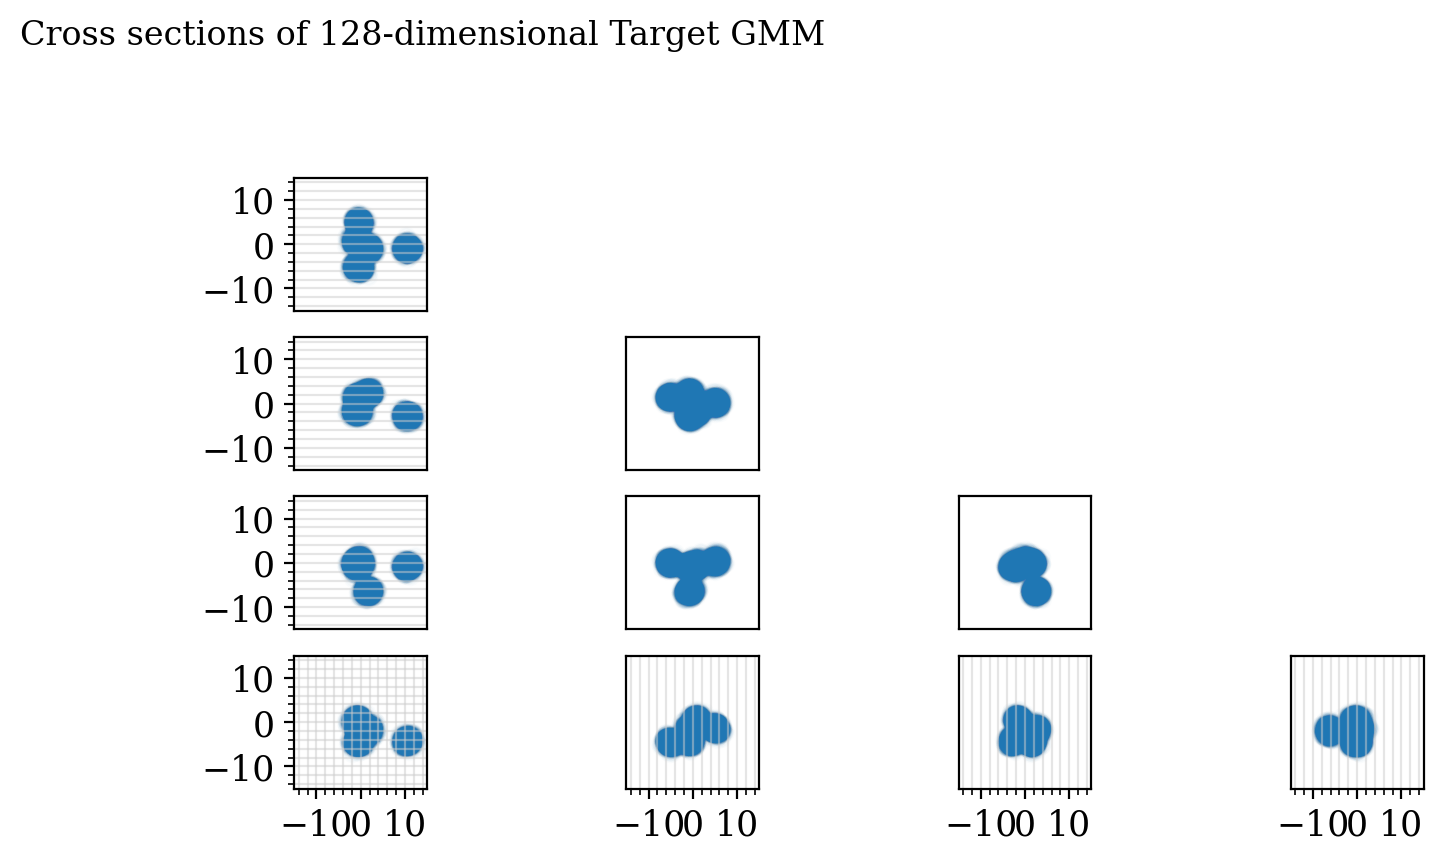

In [8]:
# construct samples
target_samples = grab(target(10000))

# set up figure
nplots    = 5
unit_size = 5
fig       = plt.figure(figsize = (unit_size*2, unit_size))
gs        = gridspec.GridSpec(nplots, nplots, figure=fig)
gs.update(wspace=0.5)

for i in range(nplots):
    for j in range(i):
        ax = plt.subplot(gs[i, j])
        ax.scatter(target_samples[:,j],target_samples[:,i], alpha=0.02)
        ax.set_xlim(-15,15)
        ax.set_ylim(-15,15)
        
        if i != nplots-1:
            ax.set_xticks([])
        if j != 0:
            ax.set_yticks([])
            
        ax.set_aspect(1.0)
        
fig.text(x = 0.01, y = 0.854, s= "Cross sections of " + str(ndim) + "-dimensional Target GMM", fontsize = 12)

Text(0.01, 0.854, 'Cross sections of 128-dimensional base GMM')

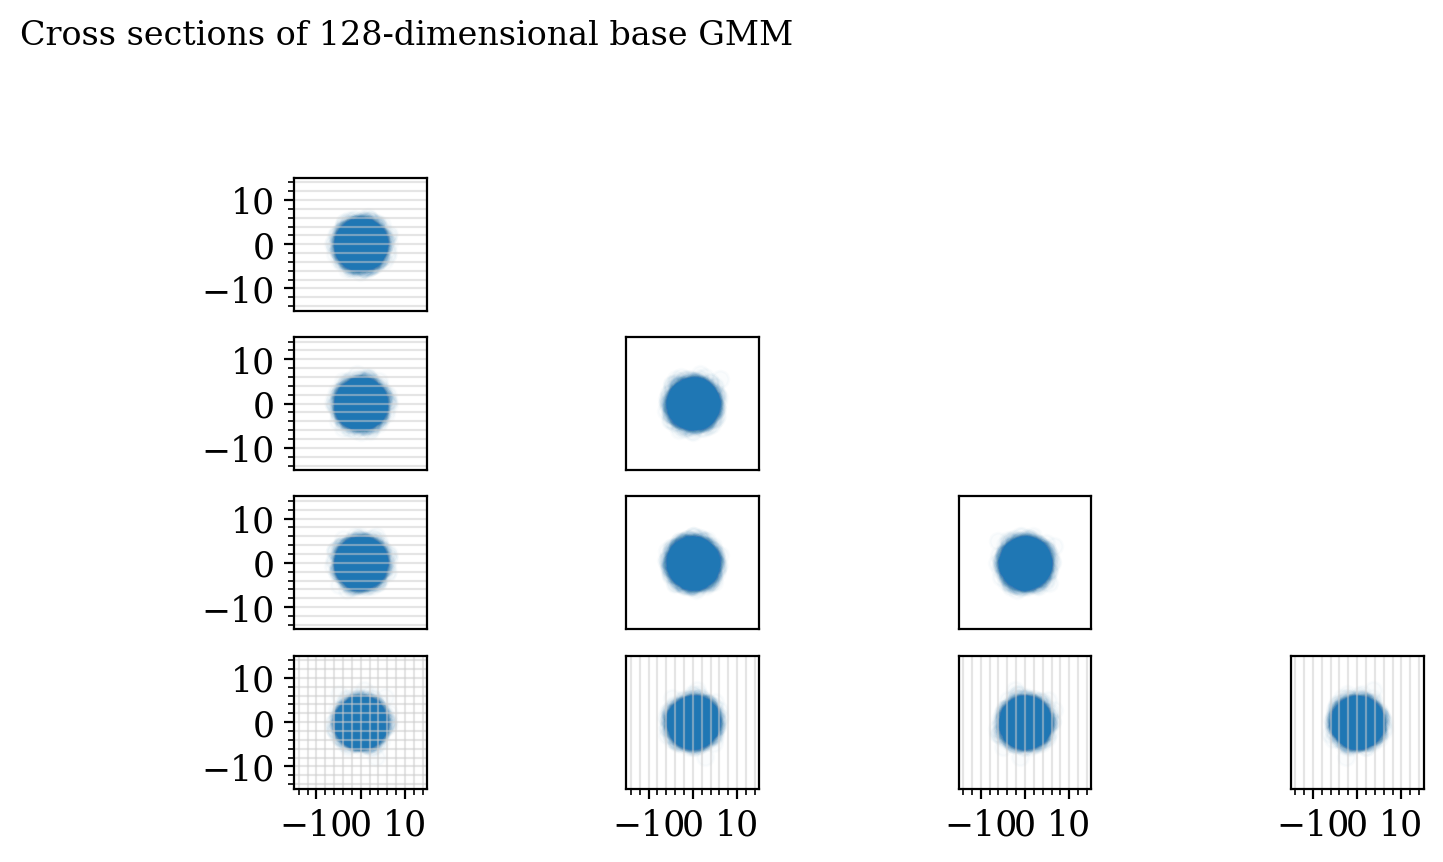

In [9]:
# construct samples
base_samples = grab(base(10000))

# set up figure
nplots    = 5
unit_size = 5
fig       = plt.figure(figsize = (unit_size*2, unit_size))
gs        = gridspec.GridSpec(nplots, nplots, figure=fig)
gs.update(wspace=0.5)

for i in range(nplots):
    for j in range(i):
        ax = plt.subplot(gs[i, j])
        ax.scatter(base_samples[:,j], base_samples[:,i], alpha=0.02)
        ax.set_xlim(-15,15)
        ax.set_ylim(-15,15)
        
        if i != nplots-1:
            ax.set_xticks([])
        if j != 0:
            ax.set_yticks([])
            
        ax.set_aspect(1.0)
        
fig.text(x = 0.01, y = 0.854, s= "Cross sections of " + str(ndim) + "-dimensional base GMM", fontsize = 12)

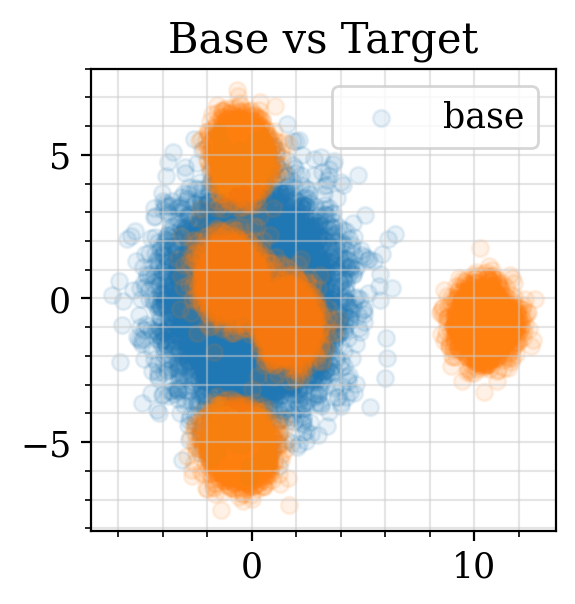

In [10]:
fig = plt.figure(figsize=(3,3,))
plt.scatter(base_samples[:,0], base_samples[:,1],  label = 'base', alpha = 0.1);
plt.scatter(target_samples[:,0], target_samples[:,1], alpha = 0.1);
plt.legend()
plt.title("Bimodal Target")
plt.title("Base vs Target")
plt.show()

### Define interpolant, velocity field, and optimizers

In [15]:
base_lr      = 2e-3
hidden_sizes = [128, 128, 128, 128]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = False

interpolant  = stochastic_interpolant.Interpolant(path=path, gamma_type=gamma_type)
v            = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
s            = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt          = torch.optim.Adam([*v.parameters(), *s.parameters()], lr=base_lr)
sched        = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=1500, gamma=0.4)

eps          = torch.tensor(0.5)
N_era        = 25
N_epoch      = 500
N_t          = 50  # number of time steps in batch (e.g. to make samples from rho_t)
plot_bs      = 500 # number of samples to use when plotting
prior_bs     = 50  # number of samples from rho_0 in batch
target_bs    = 200 # number of samples from rho_1 in batch
metrics_freq = 50  # how often to log metrics, e.g. if logp is not super cheap don't do it everytime
plot_freq    = 500 # how often to plot
n_save       = 10  # how often to checkpoint SDE integrator
loss_fac     = 4.0 # ratio of learning rates for w to v
n_likelihood = 10  # number of trajectories used to compute the SDE likelihood


if print_model:
    print("Here's the model v, s:", v, s)

[Loss: 0.01175315910950303], [Backprop: 0.22147243889048696], [Update: 0.002438714960590005].
EPOCH: 1
LOSS, GRAD: tensor(1.2283) tensor([48.0934]) tensor([10.6087])
[324.77347]
[nan]


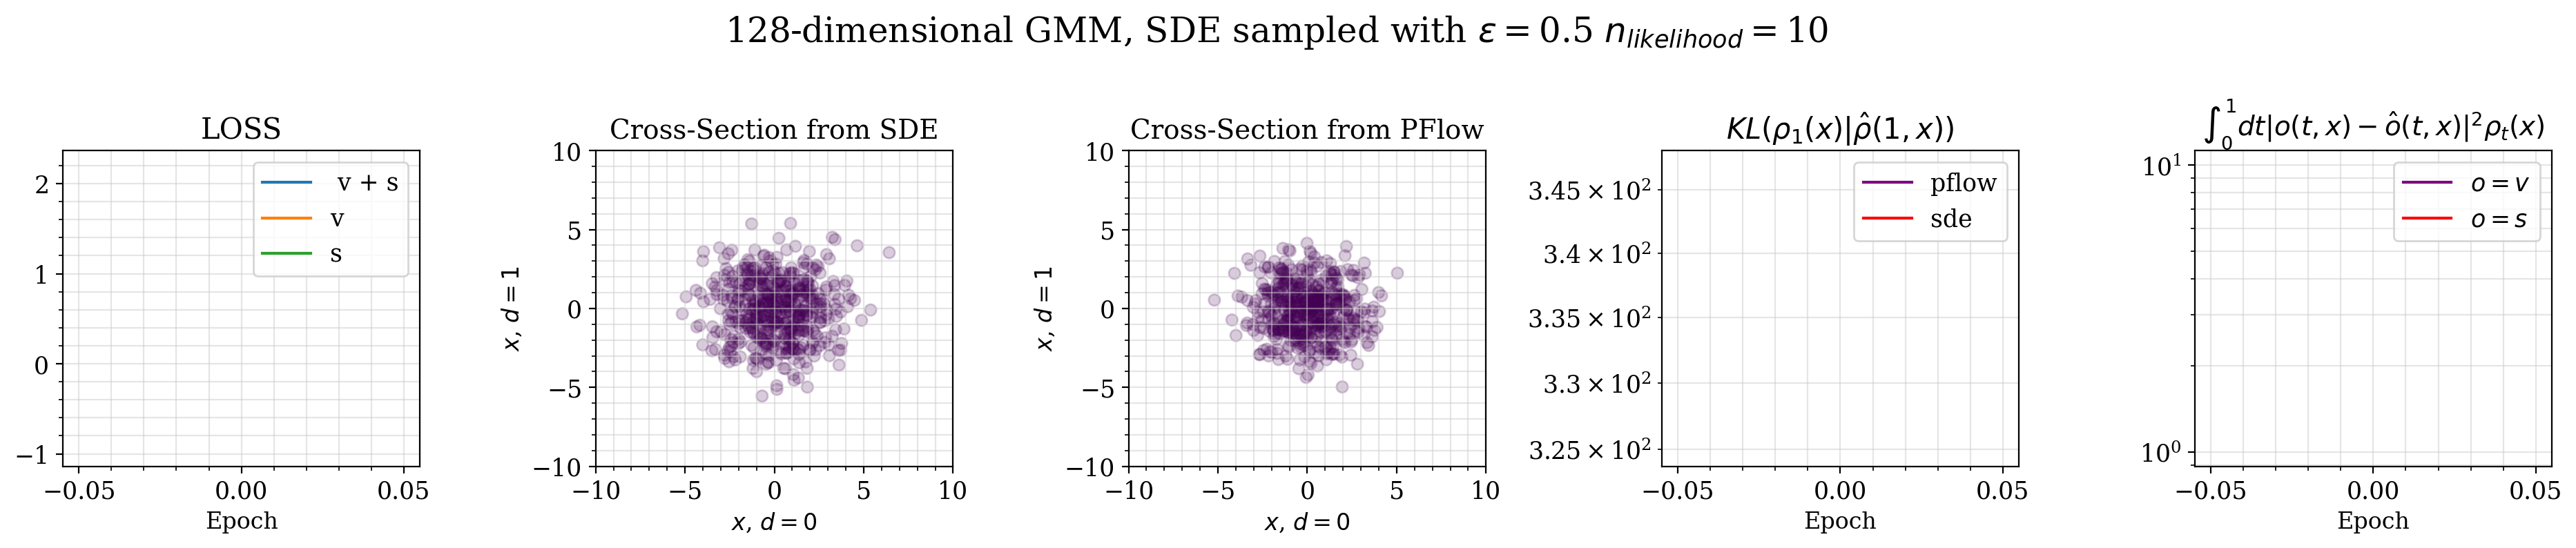

[Loss: 0.01668716687709093], [Backprop: 0.2201118329539895], [Update: 0.0017075880896300077].
[Loss: 0.005139549029991031], [Backprop: 0.2179181189276278], [Update: 0.0015781677793711424].
[Loss: 0.005091893952339888], [Backprop: 0.21689138188958168], [Update: 0.0015522059984505177].


In [ ]:
data_dict = {
    'losses': [],
    'v_losses': [],
    's_losses': [],
    'v_grads': [],
    's_grads': [],
    'times': [],
    'logps_pflow': [],
    'logps_sdeflow': [],
    'kl_pflow': [],
    'kl_sdeflow': [],
    'v_vhat_diff': [],
    's_shat_diff': []
}


counter = 1
for i, era in enumerate(range(N_era)):
    for j, epoch in enumerate(range(N_epoch)):
        loss, v_loss, s_loss, v_grad, s_grad = train_step(
            prior_bs, target_bs, N_t, interpolant, opt, sched
        )


        if (counter - 1) % metrics_freq == 0:
            log_metrics(
                v, s, exact_interpolant, interpolant, n_save, n_likelihood, 
                prior_bs, v_loss, s_loss, loss, v_grad, s_grad, eps, data_dict
            )


        if (counter - 1) % plot_freq == 0:
            make_plots(
                v, s, exact_interpolant.log_rho0, interpolant, n_save, 
                n_likelihood, plot_bs, counter, metrics_freq, eps, data_dict
            )


        counter+=1

In [ ]:

import pickle
with open('figs/data-for-figs/data_dict_d400.pkl', 'wb') as f:
    pickle.dump(data_dict, f)
    
torch.save(v, 'figs/models-for-figs/v_d400.pt')
torch.save(s, 'figs/models-for-figs/s_d400.pt')



In [ ]:
with open('figs/data-for-figs/data_dict_d400.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
    


EPOCH: 2501
LOSS, GRAD: tensor(-2193.5806) tensor([138.7220]) tensor([657.4135])
[10273.326, 687.6909, 413.16592, 381.56592, 374.7553, 353.64474, 289.57706, 278.03278, 403.32858, 331.70444, 309.48328, 257.61002, 248.22566, 303.1028, 291.7444, 282.37296, 297.7742, 283.92584, 220.40062, 269.93445, 255.07507, 207.99142, 251.17969, 215.33476, 219.16457, 200.05505, 203.27727, 226.24144, 167.20953, 165.33148, 177.55179, 147.45091, 132.4645, 157.13776, 145.1054, 135.78802, 168.38208, 150.95476, 141.43582, 149.61246, 129.24821, 131.82248, 143.16895, 139.37224, 110.62387, 138.69566, 111.76204, 127.18929, 115.311806, 119.837456]
[1245.6418, 29.751726, 37.39061, 75.11147, 50.015747, 70.824234, 23.435436, 33.87086, 24.392551, 28.192402, 38.03559, 37.964317, 26.327026, 31.846083, 23.582546, 22.272728, 27.510056, 30.519682, 48.08828, 45.730804, 14.416655, 20.9427, 31.324396, 44.5018, 33.340317, 122.02158, 17.460653, 17.849249, 39.43171, 33.626244, 34.226997, 15.44339, 154.36566, 21.806557, 28.666533

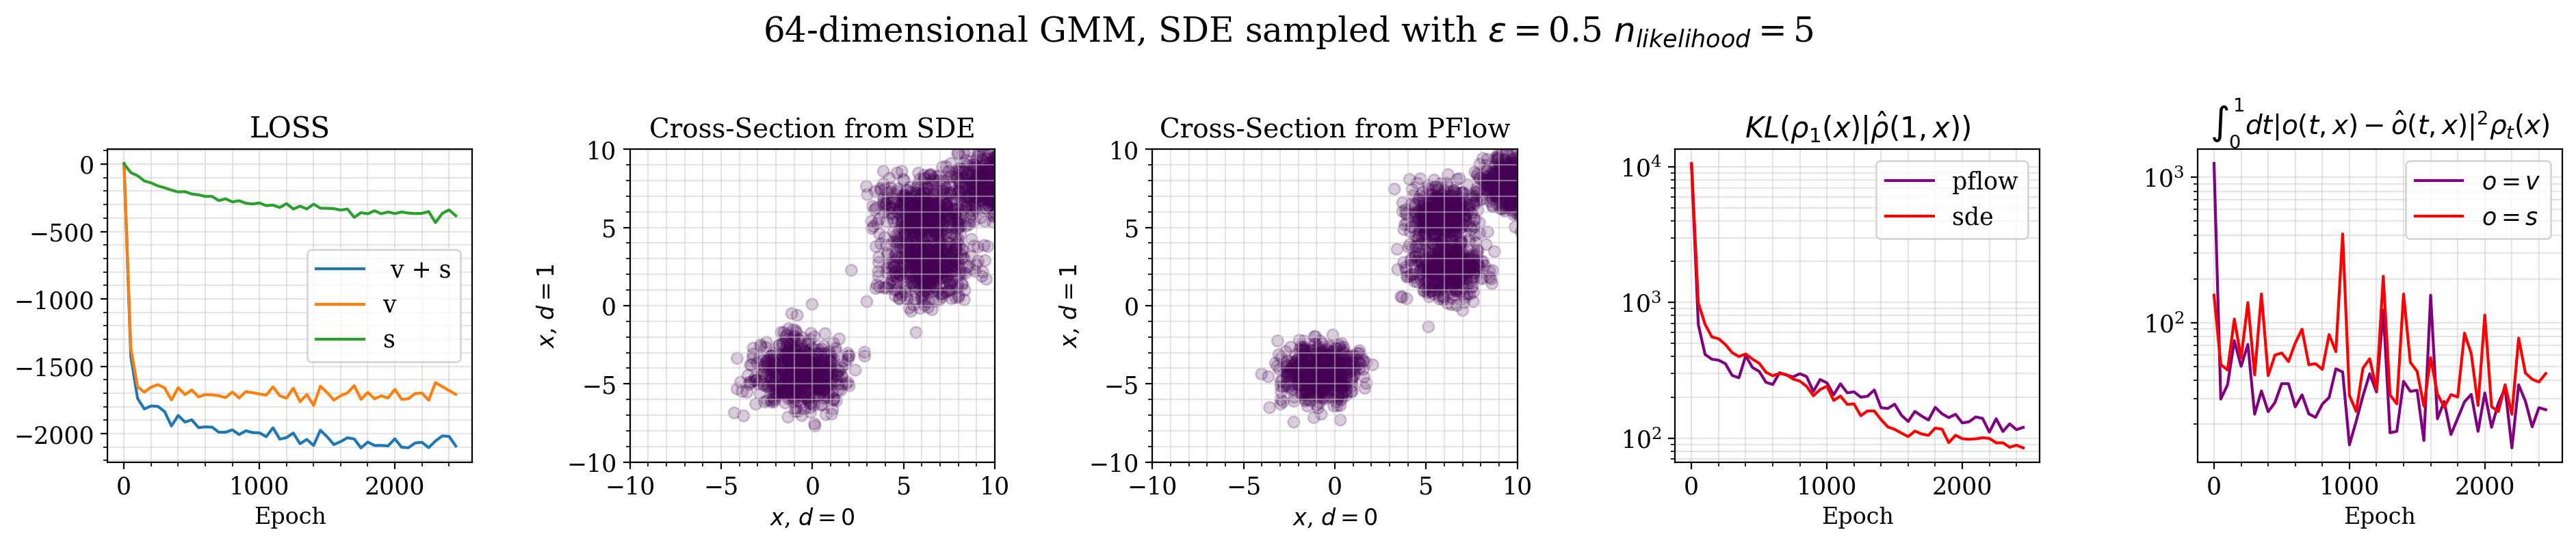

In [826]:
n_likelihood = 5
make_plots(v, s, interpolant, n_save, n_likelihood, plot_bs, counter, metrics_freq, eps, data_dict)


In [803]:
def train_step_finite_data(
    prior_bs: int,
    target_batch: int,
    N_t: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt: Any,
    sched: Any
):
    """
    Take a single step of optimization on the training set.
    """
    opt.zero_grad()


    # construct batch
    x0s = base(prior_bs)
    x1s = target_batch
    ts  = torch.rand(size=(N_t,))


    # compute the loss
    loss_start = time.perf_counter()
    loss_val, (loss_v, loss_s) = stochastic_interpolant.loss_sv(
        v_finite, s_finite, x0s, x1s, ts, interpolant, loss_fac=loss_fac
    )
    loss_end = time.perf_counter()


    # compute the gradient
    backprop_start = time.perf_counter()
    loss_val.backward()
    v_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(v_finite.parameters(), float('inf'))])
    s_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(s_finite.parameters(), float('inf'))])
    backprop_end = time.perf_counter()


    # perform the update.
    update_start = time.perf_counter()
    opt.step()
    sched.step()
    update_end = time.perf_counter()


    if counter < 5:
        print(f'[Loss: {loss_end - loss_start}], [Backprop: {backprop_end-backprop_start}], [Update: {update_end-update_start}].')


    return loss_val.detach(), loss_v.detach(), loss_s.detach(), v_grad.detach(), s_grad.detach()

In [66]:
base_lr      = 2e-3
hidden_sizes = [80, 80, 80, 80]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = False


v_finite     = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
s_finite     = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt_finite   = torch.optim.Adam([*v_finite.parameters(), *s_finite.parameters()], lr=base_lr)
sched_finite = torch.optim.lr_scheduler.StepLR(optimizer=opt_finite, step_size=1500, gamma=0.4)


eps          = torch.tensor(0.5)
N_era        = 100
N_t          = 50    # number of time steps in batch (e.g. to make samples from rho_t)
plot_bs      = 2000 # number of samples to use when plotting
prior_bs     = 25   # number of samples from rho_0 in batch
target_bs    = 100   # number of samples from rho_1 in batch
metrics_freq = 50   # how often to log metrics, e.g. if logp is not super cheap don't do it everytime
plot_freq    = 500  # how often to plot
n_save       = 10   # how often to checkpoint SDE integrator
loss_fac     = 4.0 # ratio of learning rates for w to v
n_likelihood = 20    # number of trajectories used to compute the SDE likelihood

full_bs = 2500
target_samples = target(full_bs)
N_epoch      = int(full_bs / (target_bs))
print("N EPOCH:", N_epoch)
target_batches = torch.tensor_split(target_samples, N_epoch)

if print_model:
    print("Here's the model v, s:", v, s)

N EPOCH: 25


In [67]:
data_dict_finite = {
    'losses': [],
    'v_losses': [],
    's_losses': [],
    'v_grads': [],
    's_grads': [],
    'times': [],
    'logps_pflow': [],
    'logps_sdeflow': [],
    'kl_pflow': [],
    'kl_sdeflow': [],
    'v_vhat_diff': [],
    's_shat_diff': []
}

counter = 1
for i, era in enumerate(range(N_era)):
    for j, target_batch in enumerate(target_batches):
        
        loss, v_loss, s_loss, v_grad, s_grad = train_step_finite_data(
            prior_bs, target_batch, N_t, interpolant, opt_finite, sched_finite
        )


        if (counter - 1) % metrics_freq == 0:
            log_metrics(v_finite, s_finite, exact_interpolant, interpolant, n_save, n_likelihood, prior_bs, v_loss, 
                        s_loss, loss, v_grad, s_grad, eps, data_dict_finite)


        if (counter - 1) % plot_freq == 0:
            make_plots_finite(v_finite, s_finite, interpolant, n_save, n_likelihood, plot_bs, counter, metrics_freq, eps, data_dict_finite)


        counter+=1

NameError: name 'train_step_finite_data' is not defined

In [68]:
# split = torch.tensor_split(target_samples, 250)


In [811]:
def make_plots_finite(
    v: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_likelihood: int,
    likelihood_bs: int,
    counter: int,
    metrics_freq: int,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    """Make plots to visualize samples and evolution of the likelihood."""
    # compute likelihood and samples for SDE and probability flow.
    xf_sde, logpx_sdeflow, xf_pflow, logpx_pflow = compute_likelihoods(
        v, s, interpolant, n_save, n_likelihood, eps, likelihood_bs
    )
    
    


    ### plot the loss, test logp, and samples from interpolant flow
    fig, axes = plt.subplots(1,5, figsize=(19,4))
    print("EPOCH:", counter)
    print("LOSS, GRAD:", loss, v_grad, s_grad)


    # plot loss over time.
    nsaves = len(data_dict['losses'])
    epochs = np.arange(nsaves)*metrics_freq
    axes[0].plot(epochs, data_dict['losses'], label=" v + s")
    axes[0].plot(epochs, data_dict['v_losses'], label="v")
    axes[0].plot(epochs, data_dict['s_losses'], label = "s" )
    axes[0].set_xlabel("Epoch", fontsize = 12)
    axes[0].set_title("LOSS")
    axes[0].legend()


    # plot samples from SDE.
    axes[1].scatter(
        xf_sde[:,0], xf_sde[:,1], vmin=0.0, vmax=0.05, alpha = 0.2, c=grab(torch.exp(logpx_sdeflow).detach()))
    axes[1].set_xlim(-10,10)
    axes[1].set_ylim(-10,10)
    axes[1].set_title("Cross-Section from SDE", fontsize=14)
    axes[1].set_xlabel(r"$x$, $d=0$", fontsize = 12)
    axes[1].set_ylabel(r"$x$, $d=1$", fontsize = 12)


    # plot samples from pflow
    axes[2].scatter(
        xf_pflow[:,0], xf_pflow[:,1], vmin=0.0, vmax=0.05, alpha = 0.2, c=grab(torch.exp(logpx_pflow).detach()))
    axes[2].set_xlim(-10,10)
    axes[2].set_ylim(-10,10)
    axes[2].set_title("Cross-Section from PFlow", fontsize=14)
    axes[2].set_xlabel(r"$x$, $d=0$", fontsize = 12)
    axes[2].set_ylabel(r"$x$, $d=1$", fontsize = 12)


    # plot likelihood estimates.
    
    print( data_dict['kl_pflow'])
    # epochs = epochs[:-1]
    axes[3].plot(epochs, data_dict['kl_pflow'],   label='pflow', color='purple')
    axes[3].plot(epochs, data_dict['kl_sdeflow'], label='sde',   color='red')
    axes[3].set_title(r"$KL(\rho_1(x) | \hat\rho(1,x) )$")
    axes[3].legend(loc='best')
    ymax = max(data_dict['kl_pflow'])
    # axes[3].set_ylim(-5,ymax + ymax*.01)
    axes[3].set_yscale("log")
    axes[3].set_xlabel("Epoch", fontsize = 12)
    
    print( data_dict['v_vhat_diff'])
    axes[4].plot(epochs, data_dict['v_vhat_diff'],   label=r'$o = v$', color='purple')
    axes[4].plot(epochs, data_dict['s_shat_diff'], label=r'$ o = s$',   color='red')
    axes[4].set_title(r"$\int_0^1 dt | o(t,x) - \hat o(t,x)|^2 \rho_t(x)$", fontsize = 14)
    axes[4].legend(loc='best')
    ymax = max(data_dict['v_vhat_diff'])
    # axes[4].set_ylim(-5,ymax + ymax*.01)
    axes[4].set_yscale("log")
    axes[4].set_xlabel("Epoch", fontsize = 12)


    fig.suptitle(str(ndim) + "-dimensional GMM, " + r"SDE sampled with $\epsilon = $" + str(grab(eps)) + r" $n_{likelihood} = $" 
                 + str(n_likelihood) + "; finite dataset, " + str(full_bs) + " Samples, " + str(N_era) + " sweeps over dataset", 
                 fontsize=18, y = 0.99)
    fig.tight_layout()
    plt.show()

EPOCH: 2501
LOSS, GRAD: tensor(-2142.3357) tensor([204.4925]) tensor([585.8869])
[10882.962, 938.90466, 552.3298, 364.4682, 352.57288, 342.5382, 358.5953, 381.8863, 304.415, 281.3653, 279.43616, 320.12708, 340.18085, 288.4447, 324.7122, 294.32526, 301.4213, 308.65967, 260.4514, 283.73355, 268.7033, 288.12527, 211.578, 225.56065, 232.70561, 242.23573, 216.2996, 233.60226, 191.98613, 222.01608, 195.6291, 189.05785, 189.73097, 165.84766, 172.86035, 167.5028, 199.62856, 188.02585, 170.12004, 178.01299, 180.21718, 171.07393, 163.20999, 143.27696, 130.95299, 152.51318, 162.09578, 141.1714, 159.7943, 145.14449, 145.75948]
[2145.3948, 106.982574, 141.98401, 26.81005, 43.313286, 30.614624, 28.908758, 42.86583, 30.250809, 39.50358, 30.234547, 18.744644, 25.533983, 39.905846, 57.477364, 21.737919, 20.569101, 29.396889, 27.87363, 30.285973, 28.865215, 31.614368, 19.90381, 23.91684, 46.224815, 25.359959, 12.867689, 44.268906, 27.127087, 24.983028, 26.859985, 19.238775, 29.558338, 23.700539, 48.5098

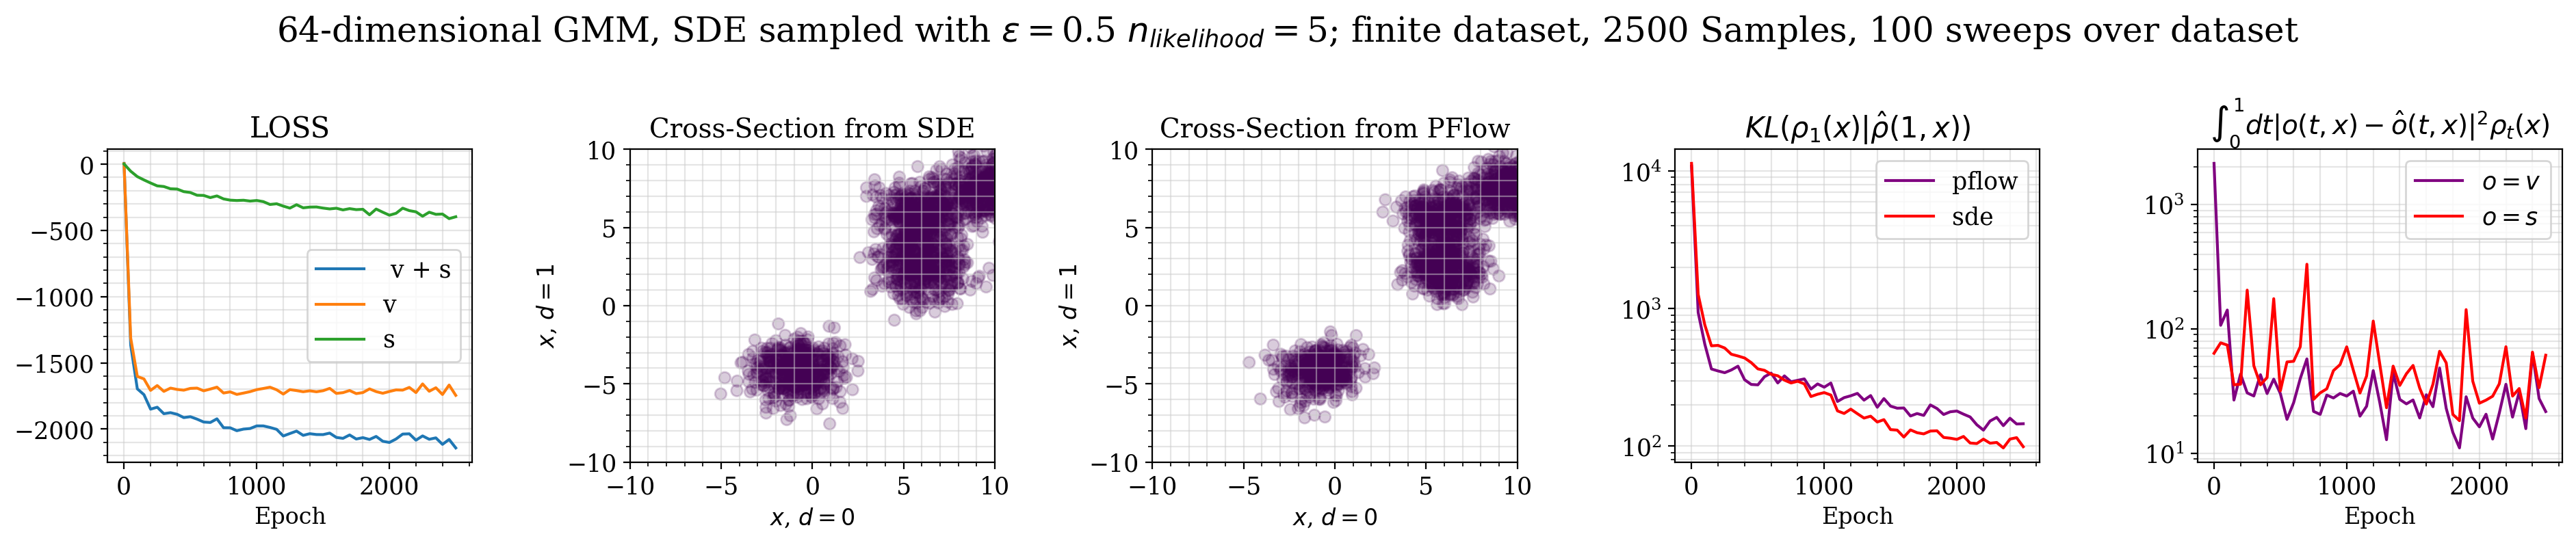

In [820]:
n_likelihood = 5
make_plots_finite(v_finite, s_finite, interpolant, n_save, n_likelihood, plot_bs, counter, metrics_freq, eps, data_dict_finite)


In [819]:
log_metrics(v_finite, s_finite, exact_interpolant, interpolant, n_save, n_likelihood, prior_bs, v_loss, 
                        s_loss, loss, v_grad, s_grad, eps, data_dict_finite)

In [806]:
print(len(data_dict_finite))

12


In [1104]:
test = itf.prior.SimpleNormal(torch.zeros(200), 5*torch.ones(200))

In [1105]:
samples = test(50)

test.log_prob(samples)

tensor([-605.5393, -620.3657, -588.0142, -610.1222, -613.3710, -603.2635,
        -610.2704, -613.0602, -611.1987, -611.8425, -576.1460, -589.3203,
        -588.2875, -604.2923, -606.0339, -614.0767, -609.6292, -606.8036,
        -599.3504, -600.9523, -609.1211, -615.7763, -618.6389, -599.2644,
        -605.1729, -608.5265, -613.6564, -616.3847, -595.2693, -605.5154,
        -603.5005, -598.8140, -595.7330, -607.9450, -608.4640, -603.1686,
        -598.8196, -594.1844, -594.0430, -609.6968, -590.8433, -597.1343,
        -603.0075, -588.8176, -616.6852, -592.3602, -616.0248, -607.3419,
        -599.3660, -618.1060])

In [1107]:
torch.exp(torch.tensor(-618,  dtype=torch.double)) 

tensor(4.0365e-269)